In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

results_path = "results/fd001_predictions_physical_features.csv"
df = pd.read_csv(results_path)

df.head()

,UnitNumber,TimeInCycles,TrueRUL,PredRUL,Effizienz_HPC_Proxy,EGT_Drift,Fan_HPC_Ratio
0,1,31,112.0,117.452675,0.941146,1.3,0.406382
1,2,49,98.0,121.172600,0.942586,-1.4,0.404988
2,3,126,69.0,45.981567,0.942525,2.2,0.404391
3,4,106,82.0,66.499170,0.944340,2.7,0.403116
4,5,98,91.0,80.357490,0.941640,1.2,0.403959


In [26]:
y_true = df["TrueRUL"].values
y_pred = df["PredRUL"].values

errors = y_pred - y_true

mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))
bias = np.mean(errors)

print(f"MSE : {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"Bias (pred - true): {bias:.3f}")


MSE : 226.691
RMSE: 15.056
MAE : 10.375
Bias (pred - true): -3.201


In [27]:
bins = [0, 25, 50, 100, 200, 400]
labels = ["0–25", "25–50", "50–100", "100–200", "200–400"]

df["RUL_bin"] = pd.cut(df["TrueRUL"], bins=bins, labels=labels, right=True)

grouped = df.groupby("RUL_bin").apply(
    lambda g: pd.Series({
        "n": len(g),
        "RMSE": np.sqrt(np.mean((g["PredRUL"] - g["TrueRUL"])**2)),
        "MAE": np.mean(np.abs(g["PredRUL"] - g["TrueRUL"])),
        "Bias": np.mean(g["PredRUL"] - g["TrueRUL"]),
    })
)

grouped


C:\Users\rober\AppData\Local\Temp\ipykernel_43604\3712030487.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("RUL_bin").apply(
C:\Users\rober\AppData\Local\Temp\ipykernel_43604\3712030487.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("RUL_bin").apply(


,n,RMSE,MAE,Bias
RUL_bin,,,,
0–25,19.0,3.053258,2.623903,0.592278
25–50,14.0,5.006732,4.264236,-2.315348
50–100,34.0,18.855051,14.565724,-1.188872
100–200,33.0,17.454374,13.111117,-7.833317
200–400,0.0,NaN,NaN,NaN


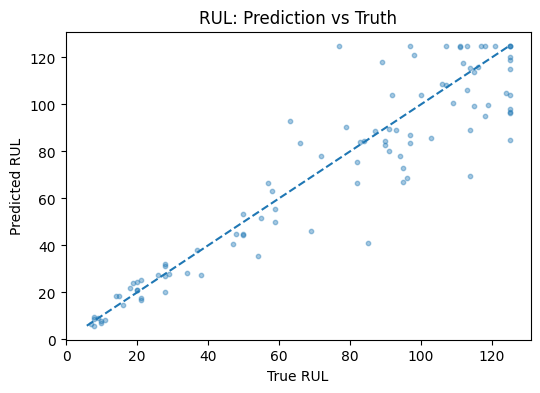

In [28]:
plt.scatter(y_true, y_pred, alpha=0.4, s=10)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL: Prediction vs Truth")
plt.show()


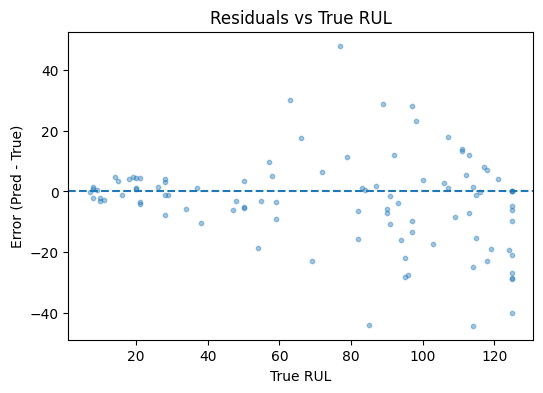

In [29]:
plt.scatter(y_true, errors, alpha=0.4, s=10)
plt.axhline(0, linestyle="--")
plt.xlabel("True RUL")
plt.ylabel("Error (Pred - True)")
plt.title("Residuals vs True RUL")
plt.show()


In [30]:
df["Error"] = df["PredRUL"] - df["TrueRUL"]

per_unit = df.groupby("UnitNumber").agg(
    n=("Error", "count"),
    RMSE=("Error", lambda e: np.sqrt(np.mean(e**2))),
    MAE=("Error", lambda e: np.mean(np.abs(e))),
    Bias=("Error", "mean"),
)

per_unit.sort_values("RMSE", ascending=False).head(10)


,n,RMSE,MAE,Bias
UnitNumber,,,,
67,1,48.000000,48.000000,48.000000
45,1,44.228820,44.228820,-44.228820
93,1,44.087452,44.087452,-44.087452
74,1,40.071160,40.071160,-40.071160
79,1,30.101845,30.101845,30.101845
86,1,28.914696,28.914696,28.914696
89,1,28.723290,28.723290,-28.723290
73,1,28.411674,28.411674,-28.411674
13,1,28.046920,28.046920,-28.046920


In [31]:
worst_units = per_unit.sort_values("RMSE", ascending=False).head(3).index.tolist()
worst_units


[67, 45, 93]

In [32]:
corr_cols = ["TrueRUL", "PredRUL", "Effizienz_HPC_Proxy", "EGT_Drift", "Fan_HPC_Ratio"]
df[corr_cols].corr()


,TrueRUL,PredRUL,Effizienz_HPC_Proxy,EGT_Drift,Fan_HPC_Ratio
TrueRUL,1.000000,0.931641,-0.098350,-0.653669,0.605295
PredRUL,0.931641,1.000000,-0.164538,-0.683138,0.646391
Effizienz_HPC_Proxy,-0.098350,-0.164538,1.000000,0.103661,-0.162089
EGT_Drift,-0.653669,-0.683138,0.103661,1.000000,-0.464545
Fan_HPC_Ratio,0.605295,0.646391,-0.162089,-0.464545,1.000000
